### Первая фаза: конверсия в триальную подписку

В первой фазе эксперимента мы проверяем гипотезу об уменьшении срока триала \
Наша задача показать, что в случае уменьшения срока пробного периода изменение конверсии не будет существенным 

**Нулевая гипотеза:** \
Конверсия в подписку при разных условиях пробного периода НЕ отличаются.

**Альтернативная гипотеза:** \
Конверсия в подписку при разных условиях пробного периода ЗНАЧИМО отличаются.

**Пояснение:**  
*в нашем случае, мы хотим, чтобы верной оказалась нулевая гипотеза, ведь если продолжительности триала не влияет на коверсию, значит мы можем поставить меньший триал, а значит пользователи будут быстрее конвертироваться в платящих.* 

В первой фазе смотрим на конверсию из first_open (первого открытия приложения) в оформление триального периода.

In [1]:
#импортируем библиотеки
import numpy as np 
import pandas as pd 
import scipy.stats as stats 
import statsmodels.stats.api as sms 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns 
from math import ceil 

#задаем переменную с базовой конерсией
base_line_rate_1 = 0.125 
#задаем переменную с ожидаемым эффектом (у нас отрицательный ожидаемый эффект, партнер считает, что станет хуже)
expected_uplift_1 = -0.03 
# Расчет размера эффекта на основе наших ожидаемых показателей 
effect_size_1 = sms.proportion_effectsize(base_line_rate_1, base_line_rate_1+expected_uplift_1) 

#Рассчитываем необходимый размер выборки
required_n_1 = sms.NormalIndPower().solve_power( 
    effect_size_1, 
    power=0.8, 
    alpha=0.05,
    ratio=1
    ) # Расчет необходимого размера выборки 

required_n_1 = ceil(required_n_1) # Округление целого числа    

print('В каждую группу необходимо минимум {} наблюдений'.format(required_n_1))

В каждую группу необходимо минимум 1701 наблюдений


#### Мы провели эксперимент, собрали данные, загрузим их в notebook и проведем разведочный анализ

In [2]:
#Читаем файл с первой фазой
data_ab = pd.read_excel('ab-test-trial.xlsx')
data_ab.head(10)

,№,group,converted_trial
0,1,trial_30_day,0
1,2,trial_30_day,0
2,3,trial_30_day,0
3,4,trial_30_day,0
4,5,trial_30_day,0
5,6,trial_30_day,0
6,7,trial_30_day,0
7,8,trial_30_day,0
8,9,trial_30_day,0
9,10,trial_30_day,0


In [3]:
converted_trial_rates = data_ab.groupby(['group']).agg({'converted_trial':'mean', '№':'count'}).reset_index()
converted_trial_rates = converted_trial_rates.rename(columns={'№':'count'})
converted_trial_rates['success'] = (converted_trial_rates['count'] * converted_trial_rates['converted_trial']).astype(int)
converted_trial_rates

,group,converted_trial,count,success
0,trial_15_day,0.110523,1701,188
1,trial_30_day,0.128748,1701,219


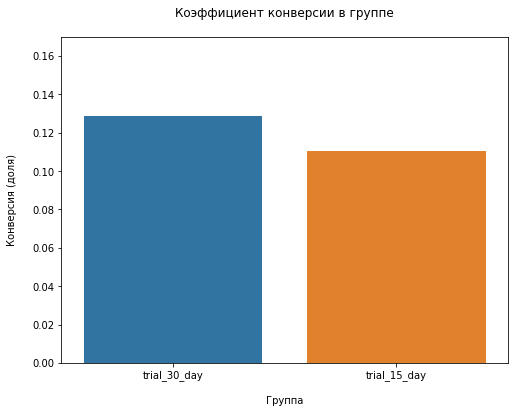

In [4]:
plt.figure(figsize=(8,6)) 

sns.barplot(x=data_ab['group'], y=data_ab['converted_trial'], ci=False) 

plt.ylim(0, 0.17) 
plt.title( 'Коэффициент конверсии в группе', pad=20) 
plt.xlabel('Группа', labelpad=15) 
plt.ylabel('Конверсия (доля)', labelpad=15);


In [5]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
trial_30_day_results_1 = data_ab[data_ab['group'] == 'trial_30_day']['converted_trial']
trial_15_day_results_1 = data_ab[data_ab['group'] == 'trial_15_day']['converted_trial']
n_30_day_1 = trial_30_day_results_1.count()
n_15_day_1 = trial_15_day_results_1.count()
successes_1 = [trial_30_day_results_1.sum(), trial_15_day_results_1.sum()]
nobs_1 = [n_30_day_1, n_15_day_1]

z_stat_1, pval_1 = proportions_ztest(successes_1, nobs=nobs_1)
(lower_30_day_1, lower_15_day_1), (upper_30_day_1, upper_15_day_1) = proportion_confint(successes_1, nobs=nobs_1, alpha=0.05)

print('z statistic: {}'.format(round(z_stat_1, 2)))
print('p-value: {}'.format(round(pval_1, 3)))
print('Доверительный интервал 95% для группы trial_15_day: [{}, {}], фактическая коверсия = {}'\
      .format(round(lower_15_day_1,3), round(upper_15_day_1,3), round(converted_trial_rates['converted_trial'][0], 3)))
print('Доверительный интервал 95% для группы trial_30_day: [{}, {}], фактическая коверсия = {}'\
      .format(round(lower_30_day_1,3), round(upper_30_day_1,3), round(converted_trial_rates['converted_trial'][1], 3)))

z statistic: 1.64
p-value: 0.101
Доверительный интервал 95% для группы trial_15_day: [0.096, 0.125], фактическая коверсия = 0.111
Доверительный интервал 95% для группы trial_30_day: [0.113, 0.145], фактическая коверсия = 0.129


#### Считается, что для категориальных переменных нужно использовать метод хи-квадрат 
Давайте проверим наши результаты используя хи-квадрат \
Оказывается хи-квадрат Пирсона получен из z-критерия путем возведения в квадрат. \
То есть p-value для z-критерия и хи-квадрата будут одинаковы, а вот значение z-критерия будет равняться квадратному корню из хи-квадрата.

In [6]:
# Создадим два списка с нашими группами 
trial_15_day_1 = [188, 1513]
trial_30_day_1 = [219, 1482]

# Расчитаем метрики теста
chi2_1, p_1, dof_1, ex_1 = stats.chi2_contingency([trial_15_day_1, trial_30_day_1], correction=False)

# Смотрим результаты
print("Хи-квадрат: {},  p-value: {}".format(round(chi2_1, 2), round(p_1, 3)))
if p_1<0.05 and converted_trial_rates['converted_trial'][0]>converted_trial_rates['converted_trial'][1]:
    print('ВЫВОД: Вариант trial_15_day лучше')
elif p_1<0.05 and converted_trial_rates['converted_trial'][0]<converted_trial_rates['converted_trial'][1]:
    print('ВЫВОД: Вариант trial_30_day лучше')
else:
    print('ВЫВОД: Нет значимых различий')

Хи-квадрат: 2.68,  p-value: 0.101
ВЫВОД: Нет значимых различий


### Вторая фаза: конверсия в платящего пользователя

Во второй фазе мы хотим проверить гипотезу об увеличении конверсии в платящего пользователя на подписке с меньшим пробным периодом.

**Нулевая гипотеза:** \
Конверсия в платного пользователя при разных условиях пробного периода НЕ отличаются.

**Альтернативная гипотеза:** \
Конверсия в платного пользователя на подписке с триалом в 15 дней выше, чем на подписке с триалом в 30 дней.

Во второй азе мы смотрим конверсию из триальной подписки в платящего пользователя (не от first_open)

In [7]:
#задаем переменную с базовой конерсией
base_line_rate_2 = 0.33 
#задаем переменную с ожидаемым эффектом (ждем, что конверсия вырастет на 7 процентов)
expected_uplift_2 = 0.07
# Расчет размера эффекта на основе наших ожидаемых показателей 
effect_size_2 = sms.proportion_effectsize(base_line_rate_2, base_line_rate_2+expected_uplift_2) 

#Рассчитываем необходимый размер выборки
required_n_2 = sms.NormalIndPower().solve_power( 
    effect_size_2, 
    power=0.8, 
    alpha=0.05,
    ratio=1
    ) # Расчет необходимого размера выборки 

required_n_2 = ceil(required_n_2) # Округление целого числа    

print('В каждую группу необходимо минимум {} наблюдений'.format(required_n_2))

В каждую группу необходимо минимум 741 наблюдений


In [8]:
#Читаем файл со второй фазой
data_ab_paid = pd.read_excel('ab-test-paid.xlsx')
data_ab_paid.head(10)

,№,group,converted_trial
0,1,trial_30_day,0
1,2,trial_30_day,0
2,3,trial_30_day,0
3,4,trial_30_day,0
4,5,trial_30_day,1
5,6,trial_30_day,0
6,7,trial_30_day,1
7,8,trial_30_day,0
8,9,trial_30_day,0
9,10,trial_30_day,0


In [9]:
converted_paid_rates = data_ab_paid.groupby(['group']).agg({'converted_trial':'mean', '№':'count'}).reset_index()
converted_paid_rates = converted_paid_rates.rename(columns={'№':'count'})
converted_paid_rates['success'] = (converted_paid_rates['count'] * converted_paid_rates['converted_trial']).astype(int)
converted_paid_rates

,group,converted_trial,count,success
0,trial_15_day,0.398111,741,295
1,trial_30_day,0.340081,741,252


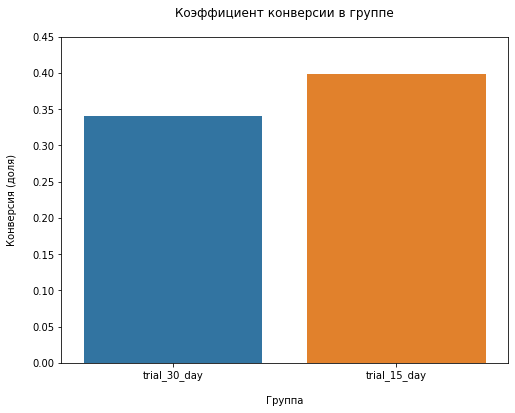

In [21]:
plt.figure(figsize=(8,6)) 

sns.barplot(x=data_ab_paid['group'], y=data_ab_paid['converted_trial'], ci=False) 

plt.ylim(0, 0.45) 
plt.title( 'Коэффициент конверсии в группе', pad=20) 
plt.xlabel('Группа', labelpad=15) 
plt.ylabel('Конверсия (доля)', labelpad=15);

In [10]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
trial_30_day_results_2 = data_ab_paid[data_ab_paid['group'] == 'trial_30_day']['converted_trial']
trial_15_day_results_2 = data_ab_paid[data_ab_paid['group'] == 'trial_15_day']['converted_trial']
n_30_day_2 = trial_30_day_results_2.count()
n_15_day_2 = trial_15_day_results_2.count()
successes_2 = [trial_30_day_results_2.sum(), trial_15_day_results_2.sum()]
nobs_2 = [n_30_day_2, n_15_day_2]

z_stat_2, pval_2 = proportions_ztest(successes_2, nobs=nobs_2)
(lower_30_day_2, lower_15_day_2), (upper_30_day_2, upper_15_day_2) = proportion_confint(successes_2, nobs=nobs_2, alpha=0.05)

print('z statistic: {}'.format(round(z_stat_2, 2)))
print('p-value: {}'.format(round(pval_2, 3)))
print('Доверительный интервал 95% для группы trial_15_day: [{}, {}], фактическая коверсия = {}'\
      .format(round(lower_15_day_2,3), round(upper_15_day_2,3), round(converted_paid_rates['converted_trial'][0], 3)))
print('Доверительный интервал 95% для группы trial_30_day: [{}, {}], фактическая коверсия = {}'\
      .format(round(lower_30_day_2,3), round(upper_30_day_2,3), round(converted_paid_rates['converted_trial'][1], 3)))

z statistic: -2.31
p-value: 0.021
Доверительный интервал 95% для группы trial_15_day: [0.363, 0.433], фактическая коверсия = 0.398
Доверительный интервал 95% для группы trial_30_day: [0.306, 0.374], фактическая коверсия = 0.34


In [11]:
# Проверим на хи-квадрат
# Создадим два списка с нашими группами 
trial_15_day_2 = [295, 446]
trial_30_day_2 = [252, 489]

# Расчитаем метрики теста
chi2_2, p_2, dof_2, ex_2 = stats.chi2_contingency([trial_15_day_2, trial_30_day_2], correction=False)

# Смотрим результаты
print("Хи-квадрат: {},  p-value: {}".format(round(chi2_2, 2), round(p_2, 3)))
if p_2<0.05 and converted_paid_rates['converted_trial'][0]>converted_paid_rates['converted_trial'][1]:
    print('ВЫВОД: Вариант trial_15_day лучше')
elif p_2<0.05 and converted_paid_rates['converted_trial'][0]<converted_paid_rates['converted_trial'][1]:
    print('ВЫВОД: Вариант trial_30_day лучше')
else:
    print('ВЫВОД: Нет значимых различий')

Хи-квадрат: 5.36,  p-value: 0.021
ВЫВОД: Вариант trial_15_day лучше
